attention+GRUのモデル

In [1]:
import numpy as np
import pandas as pd
from collections import defaultdict
import sys
import os
from keras.layers          import Lambda, Input, Dense, GRU, LSTM, Dropout
from keras.models          import Model
from keras.layers.wrappers import Bidirectional
from keras.callbacks       import LambdaCallback 
from keras.optimizers      import Adam
from keras.layers.normalization import BatchNormalization as BN
from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Merge, Dropout, LSTM, GRU, Bidirectional
from keras.models import Model
from keras import backend as K
from keras.engine.topology import Layer, InputSpec
from keras import initializers
import re
import MeCab
import math
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from gensim.models import word2vec
import numpy as np
from keras.utils import plot_model
model = word2vec.Word2Vec.load('/mnt/sdc/wikipedia_data/jawiki_wakati.model')

Using TensorFlow backend.


In [2]:
addDict={}
seq_len=13
categories=6

In [3]:
def plot_history(history):
    # 精度の履歴をプロット
    plt.plot(history.history['acc'],"o-",label="accuracy")
    plt.plot(history.history['val_acc'],"o-",label="val_acc")
    plt.title('model accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(loc="lower right")
    plt.show()

    # 損失の履歴をプロット
    plt.plot(history.history['loss'],"o-",label="loss",)
    plt.plot(history.history['val_loss'],"o-",label="val_loss")
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(loc='lower right')
    plt.show()

In [4]:
def predictVector(word, around_words_list):
    global addDict
    if word in addDict:
        return addDict[word]
    else:
        return addUnknownWord(word,around_words_list)

def addUnknownWord(word , around_words_list):
    global addDict
    rand_vector=np.random.rand(200)/np.linalg.norm(np.random.rand(200))*(10+ 3*np.random.rand(1))
    vector=np.array(model[model.predict_output_word(around_words_list)[0][0]])+rand_vector
    addDict[word]=vector
    return vector
    
def Wakati(text):
    m = MeCab.Tagger ("-Ochasen -d /usr/lib/mecab/dic/mecab-ipadic-neologd -Owakati")
    result=m.parse(text)
    ws = re.compile(" ")
    words = [word for word in ws.split(result)]
    if words[-1] == u"\n":
        words = words[:-1]
    return [word for word in words if word!="「" and word!="」" and word!="、"]

def extractKeyword(text,word_class):
    tagger = MeCab.Tagger('-Ochasen')
    tagger.parse('') # <= 空文字列をparseする
    node = tagger.parseToNode(text)
    keywords = []
    while node:
        if node.feature.split(",")[0] == word_class:
            keywords.append(node.surface)
        node = node.next
    return keywords

def seq2vecs(words,predict):
    global addDict
    vectors=[]
    for i in range(len(words)):
            try:
                vectors.append(model[words[i]])
            except:
                if predict:
                    try:
                        vectors.append(predictVector(words[i],[words[i-1]]))
                    except:
                        if i==0:
                            return []
                        else:
                            similar_word=model.similar_by_vector(addDict[words[i-1]], topn=10, restrict_vocab=None)[0][0]
                            vectors.append(predictVector(words[i],[similar_word]))
                else:
                    return []
    return vectors

In [5]:
def onehot_vector(number):
    global categories
    onehot=np.zeros(categories)
    onehot[number]=1
    return onehot

def train_test_divide(X,Y,T,test_rate):
    datanum=len(X)
    n=math.floor(datanum*test_rate)
    X_train=np.array(X[:datanum-n])
    Y_train=np.array(Y[:datanum-n])
    X_test=np.array(X[datanum-n:])
    Y_test=np.array(Y[datanum-n:])
    T_train=np.array(T[:datanum-n])
    T_test=np.array(T[datanum-n:])
    print(X_train.shape)
    print(Y_train.shape)
    print(X_test.shape)
    print(Y_test.shape)
    print(len(T_train))
    print(len(T_test))
    return (X_train,Y_train,T_train),(X_test,Y_test,T_test)

In [6]:
def load_data(filename,sfl,predict,extract):
    global seq_len
    X=[]
    Y=[]
    T=[]
    with open(filename, "r") as f:
        lines = [line for line in f]
        for line in lines:
            title,category=line.split(" ")
            words=[]
            if extract:
                words=extractKeyword(title,"名詞")
            else:
                words=Wakati(title)
            input_vectors=seq2vecs(words,predict)
            if len(input_vectors) > seq_len:
                input_vectors=input_vectors[:seq_len]
            elif len(input_vectors)==0:
                continue
            if sfl:
                random.shuffle(input_vectors)
            x = [ [0.]*200 for _ in range(seq_len) ]
            x[0:len(input_vectors)]=input_vectors
            y=onehot_vector(int(category))
            X.append(np.array(x))
            Y.append(np.array(y))
            T.append(title)
    X,Y=shuffle(X,Y)
    X=np.array(X)
    Y=np.array(Y)
    print(X.shape)
    print(Y.shape)
    print(len(T))
    return X,Y,T

In [7]:
X,Y,T=load_data("news_data.txt",False,False,False)
(X_train,Y_train,T_train),(X_test,Y_test,T_test)=train_test_divide(X,Y,T,0.1)

(68258, 13, 200)
(68258, 6)
68258
(61433, 13, 200)
(61433, 6)
(6825, 13, 200)
(6825, 6)
61433
6825


In [8]:
class AttLayer(Layer):
    def __init__(self, **kwargs):
        self.init = initializers.get('normal')
        super(AttLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape)==3
        self.W = K.variable(self.init((input_shape[-1],1)))
        self.trainable_weights = [self.W]
        super(AttLayer, self).build(input_shape)

    def call(self, x, mask=None):
        eij = K.tanh(K.dot(x,self.W))
        eij=K.squeeze(eij,axis=2)
        ai = K.exp(eij)
        Sum=K.expand_dims(K.sum(ai, axis=1),axis=1)
        weights = ai/Sum
        weights=K.expand_dims(weights,axis=1)
        weighted_input = K.batch_dot(weights, x)
        weighted_input=K.squeeze(weighted_input,axis=1)
        return weighted_input

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

In [12]:
inputs = Input(shape=(seq_len, 200))
l_lstm  = GRU(units=200, return_sequences=True)(inputs)
encoded  = AttLayer()(l_lstm)
x      = Dense(128,activation="relu")(encoded)
decoded  = Dense(categories, activation='softmax')(x)
model  = Model(inputs, decoded)
model.summary()
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])
history=model.fit(X_train, Y_train, validation_split=0.3,shuffle=True,
                  epochs=3, batch_size=30)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 13, 200)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 13, 200)           320800    
_________________________________________________________________
att_layer_2 (AttLayer)       (None, 200)               200       
_________________________________________________________________
dense_3 (Dense)              (None, 128)               25728     
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 774       
Total params: 347,502
Trainable params: 347,502
Non-trainable params: 0
_________________________________________________________________
Train on 43003 samples, validate on 18430 samples
Epoch 1/3
43003/43003 [==============================] - 58s - loss: 0.4638 - acc: 0.8

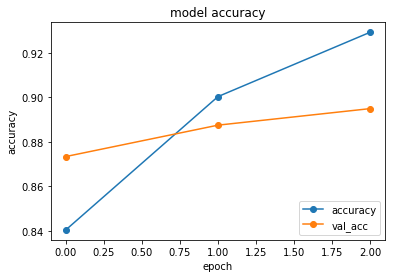

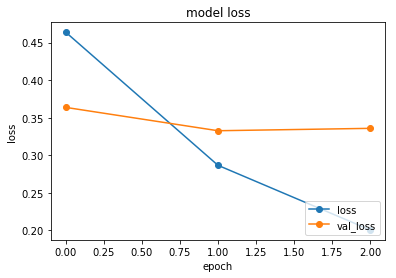

In [15]:
plot_history(history)

In [16]:
loss_and_metrics = model.evaluate(X_test,Y_test)
print("\nloss:{} accuracy:{}".format(loss_and_metrics[0],loss_and_metrics[1]))

6816/6825 [============================>.] - ETA: 0s
loss:0.3460590673977639 accuracy:0.8893772893947559
